In [1]:
import glob
import h5py
import numpy as np
from fastai.basics import *
from fastai.callback.schedule import fit_one_cycle
from fastai.callback.hook import summary
from fastai.callback.tracker import SaveModelCallback
from fastai.callback.fp16 import *
from fastai.data.load import DataLoader as FastDataLoader
from fastai.callback.progress import CSVLogger
from torch.utils.data import *
from collections.abc import Iterable
from data_utils import *

## Define Dataset

In [2]:
root = '/home/featurize/data/Generate_Data_Step_0_496_264_20020601_20190409.mat'
train_dataset = MyDataset(root, mode='train', in_channels=32, out_channels=32, steps=1)
valid_dataset = MyDataset(root, mode='valid', in_channels=32, out_channels=32, steps=1)
test_dataset = MyDataset(root, mode='test', in_channels=32, out_channels=32, steps=1)

In [3]:
batch_size = 6
device = 'cuda'
folder_to_save_models = 'weights_32-32'

train_dl = FastDataLoader(dataset=train_dataset,
                          bs=batch_size,
                          pin_memory=True,
                          shuffle=True,
                          device=torch.device(device))
valid_dl = FastDataLoader(dataset=valid_dataset,
                          bs=batch_size,
                          pin_memory=True,
                          shuffle=True,
                          device=torch.device(device))
test_dl = FastDataLoader(dataset=test_dataset,
                          bs=batch_size,
                          pin_memory=True,
                          shuffle=False,
                          device=torch.device(device))
data = DataLoaders(train_dl, valid_dl, device=torch.device(device))
test_data = DataLoaders(test_dl, device=torch.device(device))

In [4]:
from vunet_model import Net1, VUNetLoss2, valid_leaderboard, valid_leaderboard2
Model = Net1(in_channels=32,out_channels=32)

## Build Learner

In [5]:
learn = Learner(data, Model.to(device), loss_func=VUNetLoss2, metrics=[valid_leaderboard, valid_leaderboard2], model_dir=folder_to_save_models, cbs=CSVLogger)

In [6]:
learn.summary()

Net1 (Input shape: 6 x 32 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     6 x 64 x 256 x 256  
Conv2d                                    18496      True      
ELU                                                            
GroupNorm                                 128        True      
Dropout2d                                                      
Conv2d                                    55360      True      
ELU                                                            
GroupNorm                                 128        True      
Dropout2d                                                      
Conv2d                                    92224      True      
ELU                                                            
GroupNorm                                 128        True      
Dropout2d                                                      
Conv2d                                    129088     True      
ELU                    

In [10]:
# torch.cuda.empty_cache()
# torch.cuda.memory_summary()

## Training

In [11]:
learn.fit_one_cycle(2, lr_max=2e-04)

epoch,train_loss,valid_loss,valid_leaderboard,valid_leaderboard2,time
0,82.518250,6.059697,0.002984,0.002984,37:04
1,29.296463,0.066423,0.002888,0.002888,36:28


In [12]:
learn.save('Comb_2')

Path('weights/Comb_2.pth')

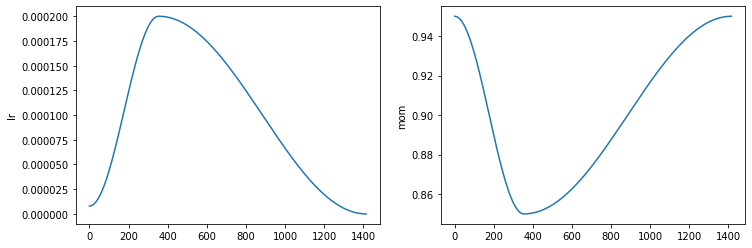

In [13]:
learn.recorder.plot_sched()

In [14]:
learn.fit_flat_cos(2, lr=2e-04, pct_start=0)

epoch,train_loss,valid_loss,valid_leaderboard,valid_leaderboard2,time
0,1.322788,0.317486,0.004964,0.004964,36:16
1,0.223381,0.004076,0.002363,0.002363,36:13


In [15]:
learn.save('Comb_4')

Path('weights/Comb_4.pth')

In [16]:
learn.fit_flat_cos(2, lr=2e-04, pct_start=0)

epoch,train_loss,valid_loss,valid_leaderboard,valid_leaderboard2,time
0,0.125142,0.052664,0.003794,0.003794,40:49
1,0.037557,0.002450,0.002057,0.002057,39:27


In [17]:
learn.save('Comb_6')

Path('weights/Comb_6.pth')

In [18]:
learn.fit_flat_cos(2, lr=2e-04, pct_start=0)

epoch,train_loss,valid_loss,valid_leaderboard,valid_leaderboard2,time
0,0.064689,0.022935,0.001123,0.001123,40:20
1,0.022693,0.002279,0.001968,0.001968,43:00


In [19]:
learn.save('Comb_8')

Path('weights/Comb_8.pth')

## Testing

In [6]:
learn.load('Comb_8')

In [7]:
x, y = test_dl.one_batch()
preds = learn.model(x)

In [55]:
# print(x.shape, y.shape)
# preds, targets = learn.get_preds(2)
pred = preds[0][0].cpu().detach().numpy()
print(pred.shape)

(32, 256, 256)


In [56]:
label = y[0].cpu().detach().numpy()
print(label.shape)

(32, 256, 256)


In [57]:
input = x[0].cpu().detach().numpy()

In [58]:
pred = recover(pred, 17, 32)
label = recover(label, 17, 32)
input = recover(input, 17, 32)

In [59]:
print(pred[:,0,0])
print(label[:,0,0])

[22.058434 22.203503 22.934628 22.622105 22.358316 22.754908 22.487421
 21.925812 22.643156 21.409224 22.700867 22.265352 23.141624 21.873486
 20.838848 22.459948 21.369762 21.35963  20.865332 21.277763 23.532818
 21.485802 22.327312 22.16201  21.699535 21.835724 21.453709 21.052456
 21.60334  21.868275 21.305529 21.04186 ]
[22.51   22.6175 22.69   22.6375 22.7575 22.7    22.9175 22.6075 22.8475
 22.66   22.87   22.645  22.76   22.915  22.535  22.645  22.49   22.95
 22.6525 22.7275 22.625  22.5325 22.6    22.6525 22.62   22.4825 22.6025
 22.7225 22.995  22.8675 23.02   23.0725]


In [60]:
diff = abs(pred - label)
print(diff)

[[[0.4515667  0.6833229  0.80093765 ... 1.0761032  1.163126   0.23841476]
  [0.6326313  0.14419937 0.2188797  ... 1.0826473  1.1649227  1.6150169 ]
  [0.7430725  0.0825119  0.12151527 ... 0.57154465 1.115675   2.0230427 ]
  ...
  [2.4041862  0.42875862 0.591877   ... 0.7346649  0.12041664 1.0701332 ]
  [2.8165379  0.30667305 0.38980484 ... 0.0402813  0.22398376 0.26994705]
  [5.1900578  2.0606499  2.0142326  ... 1.2651234  1.5611057  1.6284142 ]]

 [[0.41399765 0.70549774 0.63344383 ... 0.39460945 0.6275139  0.11293221]
  [0.15075684 0.7651844  0.3419037  ... 0.6009846  1.7866154  1.8087215 ]
  [0.2933216  0.5296478  0.31490707 ... 0.10331726 1.3869457  1.5059624 ]
  ...
  [0.11809731 0.082304   0.3400631  ... 0.03821373 0.5162811  0.65041924]
  [0.13773537 0.0229435  0.38885498 ... 0.11625671 0.35935974 0.12651443]
  [2.6878738  1.4579372  1.4616375  ... 0.37843513 0.88889694 2.4586926 ]]

 [[0.244627   0.8373146  0.65507126 ... 0.20074272 0.5136242  0.70036125]
  [0.63581467 0.403615

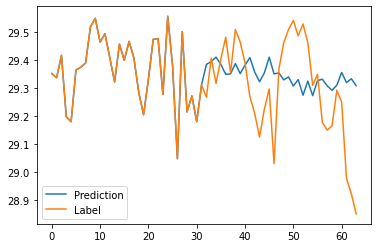

In [61]:
idx = [100, 100]
plt.plot(concat(input[...,idx[0], idx[1]], pred[...,idx[0], idx[1]]))
plt.plot(concat(input[...,idx[0], idx[1]], label[...,idx[0], idx[1]]))
plt.legend(['Prediction', 'Label'])

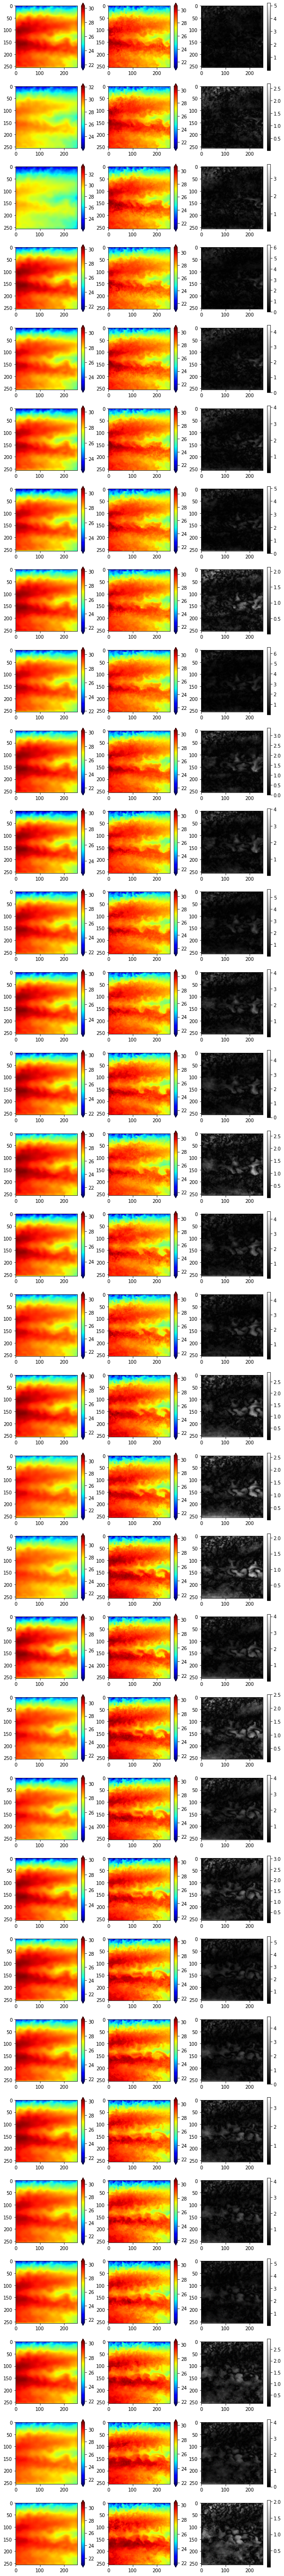

In [64]:
plt.figure(figsize=(10,100))
len = pred.shape[0]
for i in range(len):
    plt.subplot(len, 3, i*3+1)
    plt.imshow(pred[i], cmap='jet')
    plt.title('Prediction {}'.format(i+1))
    plt.colorbar(extend='both')
    plt.subplot(len, 3, i*3+2)
    plt.imshow(label[i], cmap='jet')
    plt.title('Label {}'.format(i+1))
    plt.colorbar(extend='both')
    plt.subplot(len, 3, i*3+3)
    plt.imshow(diff[i], cmap='gray')
    plt.title('Diff {}'.format(i+1))
    plt.colorbar()
